<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Hồi quy-với-Dữ Liệu Nhóm Gộp" data-toc-modified-id="Hồi quy-với-Dữ Liệu Nhóm Gộp-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Hồi quy với Dữ Liệu Nhóm Gộp</a></span></li><li><span><a href="#Hồi quy--với-các-Biến giả" data-toc-modified-id="Hồi quy--với-các-Biến giả-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Hồi quy  với các Biến giả</a></span></li><li><span><a href="#Ý-tưởng-chủ-đạo" data-toc-modified-id="Ý-tưởng-chủ-đạo-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Ý tưởng chủ đạo</a></span></li><li><span><a href="#Tài-liệu-tham-khảo" data-toc-modified-id="Tài-liệu-tham-khảo-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Tài liệu tham khảo</a></span></li></ul></div>

# Hồi quy với Dữ Liệu Nhóm Gộp
Không phải mọi điểm dữ liệu đều bình đẳng. Nếu lật lại bộ dữ liệu ENEM, chúng ta có thể tin điểm số của các trường lớn hơn các trường nhỏ. Điều này không hàm ý các trường lớn tốt hơn hoặc bất cứ điều gì tương tự. Nó chỉ dựa trên thực tế rằng cỡ mẫu lớn thường đi kèm phương sai nhỏ hơn.

In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import style
import seaborn as sns
from matplotlib import pyplot as plt
import statsmodels.formula.api as smf

style.use("fivethirtyeight")

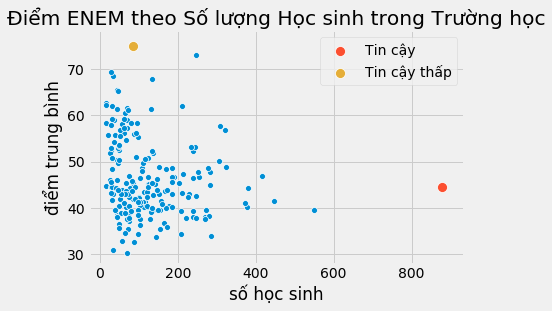

In [17]:
np.random.seed(876)
enem = pd.read_csv("./data/enem_scores.csv").sample(200).rename(columns={"avg_score":"điểm trung bình",
                                                                        "number_of_students":'số học sinh'})
# plt.figure(figsize=(8,4))
sns.scatterplot(y="điểm trung bình", x="số học sinh", data=enem)
sns.scatterplot(y="điểm trung bình", x="số học sinh", s=100, label="Tin cậy",
                data=enem[enem['số học sinh']==enem['số học sinh'].max()])
sns.scatterplot(y="điểm trung bình", x="số học sinh", s=100, label="Tin cậy thấp",
                data=enem[enem['điểm trung bình']==enem['điểm trung bình'].max()])
plt.title("Điểm ENEM theo Số lượng Học sinh trong Trường học");

Trong dữ liệu trên đây, trực giác mách bảo rằng các điểm phía bên trái lẽ ra nên chi phối mô hình ít hơn so với các điểm bên phải. Lý do là các điểm bên phải cộng gộp nhiều điểm dữ liệu đơn lẻ hơn. Nếu chúng ta có thể phân tách dữ liệu và chạy một hồi quy tuyến tính dựa vào dữ liệu phân tách, các điểm bên phải sẽ đóng góp nhiều hơn vào việc ước lượng mô hình so với các điểm bên trái.

Hiện tượng tồn tại những vùng dữ liệu với phương sai thấp bên cạnh những vùng dữ liệu với phương sai cao được gọi là **phương sai thay đổi**. Giải thích một cách đơn giản, phương sai thay đổi xảy ra nếu phương sai không cố định khi thay đổi giá trị của thuộc tính. Trong ví dụ trên, chúng ta có thể thấy  phương sai giảm khi  thuộc tính kích thước mẫu tăng. Một ví dụ khác cho phương sai thay đổi, nếu bạn vẽ đồ thị tiền lương theo tuổi tác, bạn sẽ thấy phương sai của mức lương sẽ cao hơn ở người nhiều tuổi so với người ít tuổi. Nhưng có lẽ lý do phổ biến nhất cho sự thay đổi phương sai là dữ liệu nhóm gộp.

Dữ liệu nhóm gộp giống như trường hợp trên đây vô cùng phổ biến trong phân tích dữ liệu. Một lý do thường gặp là bảo mật thông tin. Các chính phủ và công ty không được phép cung cấp thông tin cá nhân vì điều này có thể vi phạm các quy định về quyền riêng tư mà họ phải tuân thủ. Vì thế, nếu họ cần cung cấp dữ liệu cho các nhà nghiên cứu bên ngoài, họ chỉ có thể nhóm gộp dữ liệu. Bằng cách này, các cá nhân được nhóm lại với nhau và vì thế không lo bị lộ danh tính.

May mắn là hồi quy có thể xử lý khá tốt loại dữ liệu này. Để hiểu về nó, hãy nhìn vào một số dữ liệu phân tách như chúng ta có về tiền lương và giáo dục. Mỗi hàng dữ liệu cung cấp thông tin về một người lao động và cho ta biết số tiền lương cũng như số năm học vấn của người đó.

In [21]:
lương = pd.read_csv("./data/wage.csv").dropna()[["wage", "lhwage", "educ", "IQ"]].rename(columns={'wage':'lương',
                                                                                                 'lhwage':'log_lương',
                                                                                                 'educ':'học_vấn'})
lương.head()

,lương,log_lương,học_vấn,IQ
0,769,2.956212,12,93
2,825,3.026504,14,108
3,650,2.788093,12,96
4,562,2.642622,11,74
6,600,2.708050,10,91


Nếu chúng ta chạy mô hình hồi quy để tìm hiểu học vấn tương quan như thế nào với log của tiền lương theo giờ, chúng ta thu được kết quả sau:

In [23]:
model_1 = smf.ols('log_lương ~ học_vấn', data=lương).fit()
model_1.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2.3071,0.104,22.089,0.000,2.102,2.512
học_vấn,0.0536,0.008,7.114,0.000,0.039,0.068


Tuy nhiên, hãy vờ như dữ liệu trên đây bị hạn chế do bảo mật thông tin. Nhà cung cấp không được phép tiết lộ thông tin cá nhân. Vì thế, chúng ta đề nghị họ nhóm gộp các cá nhân theo số năm học vấn và cung cấp cho chúng ta mức bình quân của log tiền lương theo giờ và số cá nhân trong mỗi nhóm. Việc này giúp chúng ta thu được 10 điểm dữ liệu.

In [40]:
lương_gộp = (lương
              .assign(số_người=1)
              .groupby("học_vấn")
              .agg({"log_lương":"mean", "số_người":"count"})
              .reset_index())

lương_gộp

,học_vấn,log_lương,số_người
0,9,2.679533,4
1,10,2.730512,21
2,11,2.878807,25
3,12,2.949520,270
4,13,3.101693,56
5,14,3.007821,53
6,15,3.176634,32
7,16,3.176659,121
8,17,3.259375,35
9,18,3.178160,46


Đừng lo lắng! Hồi quy không phải lúc nào cũng đòi hỏi dữ liệu lớn để hoạt động! Điều chúng ta cần làm là cung cấp các trọng số cho mô hình hồi quy tuyến tính. Bằng cách này, nó sẽ xem trọng các nhóm với kích thước mẫu lớn hơn các nhóm nhỏ. Lưu ý việc tôi thay thế `smf.ols` bằng `smf.wls` để thực hiện bình phương trọng số tối thiểu  (weighted least squares). Có vẻ hơi khó nhận biết nhưng nó thực sự tạo ra khác biệt lớn.

In [41]:
model_2 = smf.wls('log_lương ~ học_vấn', data=lương_gộp, weights=lương_gộp["số_người"]).fit()
model_2.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2.3071,0.108,21.321,0.000,2.058,2.557
học_vấn,0.0536,0.008,6.867,0.000,0.036,0.072


Lưu ý ước lượng hệ số  `educ` trong mô hình nhóm gộp đúng bằng mô hình với dữ liệu phân tách. Hơn nữa, chỉ với 10 điểm dữ liệu, chúng ta đã thu về một hệ số có ý nghĩa thống kê! Đó là bởi vì mặc dù chúng ta có ít điểm dữ liệu hơn, việc nhóm gộp cũng làm giảm phương sai khá nhiều. Cũng cần lưu ý việc sai số chuẩn trở nên lơn hơn và tương tự với thống kê t. Đó là hậu quả của việc mất bớt thông tin về phương sai, và vì thế chúng ta cần thận trọng hơn. Khi nhóm gộp dữ liệu, chúng ta không biết phương sai trong mỗi nhóm. Hãy so sánh kết quả trên với mô hình không có trọng số dưới đây.

In [43]:
model_3 = smf.ols('log_lương~ học_vấn', data=lương_gộp).fit()
model_3.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2.1739,0.111,19.497,0.000,1.917,2.431
học_vấn,0.0622,0.008,7.702,0.000,0.044,0.081


Ước lượng hệ số trở nên lớn hơn. Điều xảy ra ở đây là mô hình hồi quy đặt trọng số như nhau cho tất cả các điểm. Nếu chúng ta vẽ đồ thị các mô hình theo các điểm nhóm gộp, chúng ta thấy mô hình không trọng số quá xem trọng các điểm nhỏ góc bên trái phía dưới hơn. Hậu quả là đường hồi quy dốc hơn.

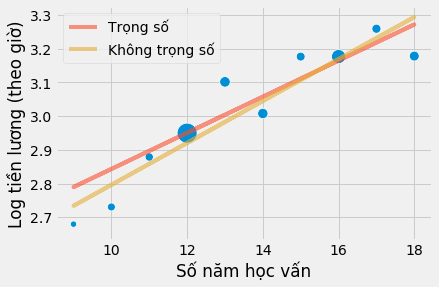

In [46]:
sns.scatterplot(x="học_vấn", y = "log_lương", size="số_người", legend=False, data=lương_gộp, sizes=(40, 400))
plt.plot(wage["học_vấn"], model_2.predict(wage["học_vấn"]), c="C1", label = "Trọng số",alpha=0.6)
plt.plot(wage["học_vấn"], model_3.predict(wage["học_vấn"]), c="C2", label = "Không trọng số",alpha=0.6)
plt.xlabel("Số năm học vấn")
plt.ylabel("Log tiền lương (theo giờ)")
plt.legend();

Điểm mấu chốt là hồi quy là một công cụ kì diệu, có thể được sử dụng với cả dữ liệu cá nhân và dữ liệu nhóm gộp, tuy nhiên bạn phải sử dụng các trọng số như trường hợp trên đây. Để sử dụng hồi quy trọng số, bạn cần các giá trị thống kê trung bình. Không phải tổng, độ lệch chuẩn mà phải là giá trị trung bình của cả các  biến giải thích và biến phụ thuộc. Với trường hợp hồi quy hai biến, kết quả của  hồi quy trọng số sử dụng dữ liệu nhóm gộp không hoàn toàn giống hệt hồi quy với dữ liệu phân tách nhưng khá tương tự. 

![img](./data/img/dummy/heterosk.png)


Tôi sẽ dừng lại với một ví dụ sử dụng nhiều biến giải thích trong mô hình dữ liệu nhóm gộp.

In [54]:
lương_gộp = (lương
              .assign(số_người=1)
              .groupby("học_vấn")
              .agg({"log_lương":"mean", "IQ":"mean", "số_người":"count"})
              .reset_index())

model_4 = smf.ols('log_lương ~ học_vấn + IQ', data=lương_gộp).fit()
print("Số quan sát:", model_4.nobs)
model_4.summary().tables[1]

Số quan sát: 10.0


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1.9747,0.427,4.629,0.002,0.966,2.983
học_vấn,0.0464,0.034,1.377,0.211,-0.033,0.126
IQ,0.0041,0.008,0.486,0.642,-0.016,0.024


# Hồi quy  với các Biến giả

Biến giả là các biến phân loại mà chúng ta mã hóa dưới dạng cột nhị phân. Ví dụ, giả sử bạn có biến giới tính và muốn sử dụng nó trong mô hình. Biến này được mã hóa theo 3 nhóm: nam, nữ và giới tính khác. 

|giới tính|
|------|
|  |
|nữ|
|nữ|
|khác |
|nam  |

Vì mô hình của chúng ta chỉ chấp nhận các giá trị bằng số, chúng ta cần chuyển đổi các nhóm này thành số. Trong hồi quy tuyến tính, chúng ta sử dụng các biến giả cho mục đích này. Chúng ta mã hóa mỗi biến dưới dạng các cột 0/1, tùy theo nhóm có hiện diện hay không. Chúng ta không mã hóa một trong số các  nhóm mà sử dụng nó làm nhóm tham chiếu. Điều này là cần thiết vì nhóm này là tổ hợp tuyến tính của các nhóm khác. Nói cách khác, chúng ta tính giá trị của nhóm này nếu ai đó cho chúng ta biết thông tin về tất cả các nhóm khác. Trong ví dụ của chúng ta, nếu ai đó không phải nữ và không thuộc giới tính khác thì hẳn người đó phải là nam.

|giới tính|nữ|khác|
|------|:-----|:----|
|nam  |0|0|
|nữ|1|0|
|nữ|1|0|
|khác |0|1|
|nam  |0|0|


Chúng ta đã giải quyết một dạng đơn giản của hồi quy biến giả khi thực hiện kiểm định A/B. Khái quát hơn, khi chúng ta đối mặt với một can thiệp nhị phân, chúng ta biểu diễn nó dưới dạng một biến giả. Trong trường  hợp này **hệ số hồi quy của biến giả là sự dịch chuyển hệ số chặn của đường hồi quy**, hoặc hiệu của giá trị trung bình giữa nhóm được can thiệp và đối chứng.

Để hiểu rõ điều này hơn, hãy xem xét bài toán ước lượng tác động của việc học hết lớp 12 đối với  tiền lương theo giờ (để đơn giản hóa chúng ta không cân nhắc các biến nhiễu trong ví dụ này). Ở dòng code dưới đây, chúng ta khởi tạo một biến giả can thiệp `L12` để chỉ số năm học vấn lớn hơn hoặc bằng 12. 

In [59]:
lương = (pd.read_csv("./data/wage.csv").rename(columns={'wage':'lương','hours':'số_giờ','educ':'học_vấn' })
        .assign(lương_giờ=lambda d: d["lương"] / d["số_giờ"])
        .assign(L12=lambda d: (d["học_vấn"] > 12).astype(int)))

lương[["lương_giờ", "IQ", "L12"]].head()

,lương_giờ,IQ,L12
0,19.225,93,0
1,16.160,119,1
2,20.625,108,1
3,16.250,96,0
4,14.050,74,0


Biến giả hoạt động như một loại công tắc. Trong ví dụ của chúng ta, nếu biến giả được bật, giá trị dự đoán bằng hệ số chặn cộng với hệ số biến giả. Nếu biến giả tắt, giá trị dự đoán chỉ bằng hệ số chặn. 

In [60]:
smf.ols('lương_giờ ~ L12', data=lương).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,19.9405,0.436,45.685,0.000,19.084,20.797
L12,4.9044,0.626,7.830,0.000,3.675,6.134


Trong trường hợp này, khi một người chưa học xong lớp 12 (biến giả tắt), thu nhập bình quân là 19.9. Khi anh ta hoặc cô ta học xong (biến giả bật), giá trị dự đoán hoặc thu nhập bình quân là 24.8449 (19.9405 + 4.9044). Vì vậy, hệ số biến giả phản ánh sự khác biệt của các giá trị trung bình, trong trường hợp này là 4.9044.

Nói cách khác, khi biến phụ thuộc là biến nhị phân, một hiện tượng khá phổ biến với chỉ số can thiệp, hồi quy phản ảnh chính xác ATE. Bởi vì hồi quy là phép xấp xỉ tuyến tính của hàm kì vọng có điều kiện [CEF] \\(E[Y|X]\\) và trong trường hợp cụ thể này CEF tuyến tính. Chúng ta có thể định nghĩa \\(E[Y_i|L12_i=0]=\alpha\\) và \\(E[Y_i|L12_i=1] = \alpha + \beta\\), từ đó thu được CEF sau


$
E[Y_i|L12_i] =  E[Y_i|L12_i=0] + \beta L12_i = \alpha + \beta L12_i
$

và \\(\beta\\) là hiệu của các giá trị trung bình hoặc ATE trong trường hợp dữ liệu ngẫu nhiên

$
\beta = [Y_i|L12_i=1] - [Y_i|L12_i=0]
$

Nếu chúng ta sử dụng thêm các biến khác, hệ số biến giả trở thành hiệu có điều kiện của các giá trị trung bình. Ví dụ, nếu chúng ta bổ sung biến IQ vào mô hình trên. Bây giờ, hệ số biến giả cho chúng ta biết chúng ta nên kì vọng tiền lương tăng thêm bao nhiêu sau khi tốt nghiệp lớp 12 **khi cố định IQ**. Nếu chúng ta vẽ biểu đồ dự đoán, chúng ta sẽ thấy hai đường thẳng song song. Khoảng cách giữa hai đường cho biết số tiền chúng ta nên kì vọng do học hết lớp 12. Chúng cũng nói rằng tác động là cố định. Bất kể IQ bao nhiêu, mọi người đều hưởng lợi như nhau nhờ vào việc học hết lớp 12. 

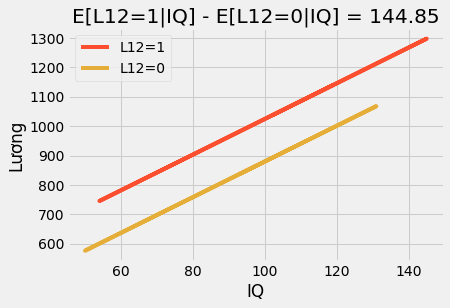

In [64]:
m = smf.ols('lương ~ L12+IQ', data=lương).fit()
plt_df = lương.assign(y_hat = m.fittedvalues)

plt.plot(plt_df.query("L12==1")["IQ"], plt_df.query("L12==1")["y_hat"], c="C1", label="L12=1")
plt.plot(plt_df.query("L12==0")["IQ"], plt_df.query("L12==0")["y_hat"], c="C2", label="L12=0")
plt.title(f"E[L12=1|IQ] - E[L12=0|IQ] = {round(m.params['L12'], 2)}")
plt.ylabel("Lương")
plt.xlabel("IQ")
plt.legend();

Nếu viết mô hình này dưới dạng phương trình, chúng ta có thể thấy tại sao:

$
wage_i = \beta_0 + \beta_1L12_i + \beta_2 IQ_i + e_i
$

Ở đây, \\(\beta_1\\) là hiệu có điều kiện của các giá trị trung bình  và là giá trị cố định, 3.16 trong trường hợp của chúng ta. Chúng ta có thể tăng độ linh hoạt của mô hình bằng cách bổ sung một phần tương tác.

$
wage_i = \beta_0 + \beta_1L12_i + \beta_2 IQ_i + \beta_3 IQ_i * L12_i  + e_i
$

Hãy xem mỗi tham số trong mô hình này nói lên điều gì vì mọi thứ trông có vẻ phức tạp hơn một chút. Trước hết, hệ số chặn \\(\beta_0\\). Gã khờ này chán òm. Hắn phản ánh mức lương kì vọng khi can thiệp bằng 0 (một người chưa học hết lớp 12) và IQ bằng 0. Vì chúng ta không kì vọng bất kì ai có IQ bằng 0, tham số này thực ra chẳng mấy ý nghĩa. Bây giờ, khi chuyển sang \\(\beta_1\\), chúng ta rơi vào tình huống tương tự. Tham số này cho biết lượng tiền lương tăng khi hoàn thành lớp 12 với **IQ bằng không**. Nhắc lại vì IQ chẳng bao giờ bằng 0, nó chẳng có chút ý nghĩa thú vị nào. Tiếp theo, \\(\beta_2\\) đáng nói hơn một chút. Nó cho ta biết IQ  làm tăng mức lương thêm bao nhiêu **đối với nhóm đối chứng**. Trong trường hợp này, con số đó rơi vào khoảng 0.11. Nghĩa là, với mỗi điểm IQ tăng thêm, một người chưa học xong lớp 12 có thể kiếm thêm 11 cent mỗi giờ. Cuối cùng, tham số thú vị nhất là is \\(\beta_3\\). Nó cho ta biết IQ làm tăng tác động của việc học hết lớp 12 thêm bao nhiêu. Trong ví dụ của chúng ta, tham số này bằng 0.024, nghĩa là với mỗi điểm IQ cao hơn, người học hết lớp 12 thu được thêm 2 cent. Trông có vẻ không nhiều, nhưng hãy thử so một người có IQ 60 với một người có IQ 140. Người thứ nhất sẽ thu được thêm 1.44 cent mỗi giờ (60 * 0.024),trong khi người thứ 2 với IQ 140 thu được thêm  3.36 đô-la (60 * 0.024) nhờ vào tấm bằng tốt nghiệp lớp 12.

Trong mô hình biến thể đơn giản này, phần tương tác cho phép tác động can thiệp thay đổi theo cấp độ các thuộc tính (IQ, trong trường hơp này). Kết quả là nếu chúng ta vẽ biểu đồ các đường dự đoán, chúng ta sẽ thấy chúng không còn song song nữa mà đồ thị cho những người học xong lớp 12 (T=1) có  độ dốc theo IQ cao hơn: những người có IQ cao hưởng lợi từ tấm bằng tốt nghiệp nhiều hơn so với người IQ thấp.

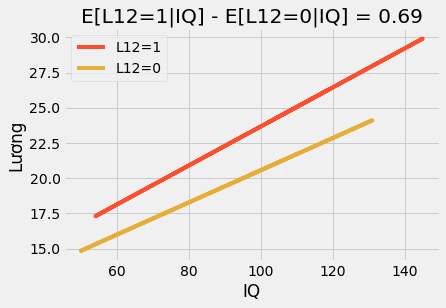

In [67]:
m = smf.ols('lương_giờ ~ L12*IQ', data=lương).fit()
plt_df = lương.assign(y_hat = m.fittedvalues)

plt.plot(plt_df.query("L12==1")["IQ"], plt_df.query("L12==1")["y_hat"], c="C1", label="L12=1")
plt.plot(plt_df.query("L12==0")["IQ"], plt_df.query("L12==0")["y_hat"], c="C2", label="L12=0")
plt.title(f"E[L12=1|IQ] - E[L12=0|IQ] = {round(m.params['L12'], 2)}")
plt.ylabel("Lương")
plt.xlabel("IQ")
plt.legend();

Cuối cùng, hãy xem xét trường hợp với tất cả các  biến trong mô hình đều là biến giả. Để làm điều này, chúng ta sẽ phân chia IQ thành 4 nhóm và sử dụng biến số năm học vấn như là một biến phân loại.

In [70]:
lương_nhóm = (lương
                .assign(IQ_nhóm = lambda d: pd.qcut(d["IQ"], q=4, labels=range(4)))
                [["lương_giờ", "học_vấn", "IQ_nhóm"]])

lương_nhóm.head()

,lương_giờ,học_vấn,IQ_nhóm
0,19.225,12,1
1,16.160,18,3
2,20.625,14,2
3,16.250,12,1
4,14.050,11,0


Sử dụng biến học vấn như là một biến phân loại nghĩa là chúng ta không giới hạn tác động của giáo dục bằng một tham số đơn lẻ nữa. Thay vào đó, chúng ta cho phép mỗi năm học vấn có ảnh hưởng riêng. Làm như vậy, chúng ta tăng mức độ linh hoạt của mô hình vì tác động của giáo dục không có tham số nữa. Điều xảy ra với mô hình này là nó đơn thuần tính mức lương trung bình theo mỗi năm học vấn.

In [71]:
model_dummy = smf.ols('lương_giờ ~ C(học_vấn)', data=lương).fit()
model_dummy.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,18.5600,3.011,6.164,0.000,12.651,24.469
C(học_vấn)[T.10],-0.7874,3.414,-0.231,0.818,-7.488,5.913
C(học_vấn)[T.11],0.1084,3.343,0.032,0.974,-6.452,6.669
C(học_vấn)[T.12],1.7479,3.049,0.573,0.567,-4.236,7.732
C(học_vấn)[T.13],4.3290,3.183,1.360,0.174,-1.918,10.576
C(học_vấn)[T.14],4.0888,3.200,1.278,0.202,-2.192,10.370
C(học_vấn)[T.15],6.3013,3.329,1.893,0.059,-0.231,12.834
C(học_vấn)[T.16],7.2225,3.110,2.323,0.020,1.120,13.325
C(học_vấn)[T.17],9.5905,3.366,2.849,0.004,2.984,16.197
C(học_vấn)[T.18],7.3681,3.264,2.257,0.024,0.962,13.775


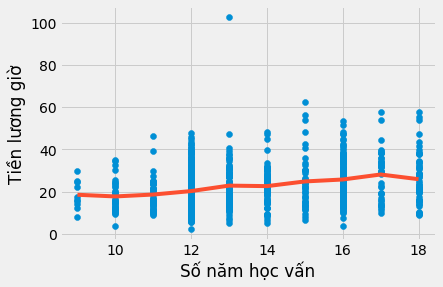

In [72]:
plt.scatter(lương["học_vấn"], lương["lương_giờ"])
plt.plot(lương["học_vấn"].sort_values(), model_dummy.predict(lương["học_vấn"].sort_values()), c="C1")
plt.xlabel("Số năm học vấn")
plt.ylabel("Tiền lương giờ");

Trước hết, hãy lưu ý việc này loại bỏ các giả thiết về dạng phương trình của tác động của giáo dục lên tiền lương. Chúng ta không cần lo lắng về log nữa. Quan trọng là mô hình này hoàn toàn phi tham số.Tất cả những gì nó làm là tính toán mức lương bình quân cho mỗi mức học vấn. Có thể thấy điều này từ đồ thị bên trên, với các đường hồi quy không có dạng định sẵn. Thay vào đó, là việc nội suy các giá trị trung bình của mẫu cho mỗi mức học vấn. Chúng ta cũng có thể thấy việc việc ước lượng tham số, ví dụ cho mức học vấn 17 năm. Trong mô hình này, chúng ta ước lượng được mức `9.5905`. Dưới đây chúng ta sẽ thấy hệ số này chính là hiệu của mức học vấn tham chiếu (9) và các cá nhân có 17 năm học vấn.

$
\beta_{17} = E[Y|T=17]-E[Y|T=9]
$

Cái giá của sự linh hoạt là chúng ta mất ý nghĩa thống kê. Hãy để ý các trị số p khá lớn cho nhiều mức học vấn.

In [73]:
t1 = lương.query("học_vấn==17")["lương_giờ"]
t0 = lương.query("học_vấn==9")["lương_giờ"]
print("E[Y|T=9]:", t0.mean())
print("E[Y|T=17]-E[Y|T=9]:", t1.mean() - t0.mean())

E[Y|T=9]: 18.56
E[Y|T=17]-E[Y|T=9]: 9.59047236235352


Nếu chúng ta đưa thêm nhiều biến giải thích giả vào mô hình, các tham số của học vấn trở thành bình quân trọng số của tác động trên mỗi nhóm biến giả:

$
E\{ \ (E[Y_i|T=1, Nhóm_i] - E[Y_i|T=0, Nhóm_i])w(Nhóm_i) \ \}
$

\\(w(Nhóm_i)\\) không hoàn toàn chính xác, nhưng tỉ lệ thuận với phương sai của can thiệp trong nhóm \\(Var(T_i|Nhóm_i)\\). Một câu hỏi tự nhiên phát sinh là tại sao không sử dụng mô hình ước lượng phi tham số, với trọng số của nhóm là kích thước mẫu? Nó là một mô hình ước lượng hợp lý, nhưng không phải là cái mà hồi quy hướng đến. Bằng cách sử dụng phương sai can thiệp, hồi quy đặt trọng số cao hơn cho các nhóm với lượng can thiệp biến đổi nhiều. Điều này có lý hơn. Nếu lượng can thiệp gần như cố định (ví dụ chỉ 1 người được can thiệp và tất cả người khác là đối chứng), kích thước mẫu chẳng còn nghĩa lý gì, và nó không cung cấp mấy thông tin về tác động can thiệp.

In [74]:
model_dummy_2 = smf.ols('lương_giờ ~ C(học_vấn) + C(IQ_nhóm)', data=lương_nhóm).fit()
model_dummy_2.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,18.4178,2.991,6.158,0.000,12.548,24.288
C(học_vấn)[T.10],-1.2149,3.392,-0.358,0.720,-7.872,5.442
C(học_vấn)[T.11],-0.4687,3.332,-0.141,0.888,-7.008,6.070
C(học_vấn)[T.12],0.3400,3.059,0.111,0.912,-5.664,6.344
C(học_vấn)[T.13],2.4103,3.206,0.752,0.452,-3.882,8.702
C(học_vấn)[T.14],1.8040,3.238,0.557,0.578,-4.551,8.159
C(học_vấn)[T.15],3.8599,3.369,1.146,0.252,-2.752,10.472
C(học_vấn)[T.16],4.4060,3.171,1.390,0.165,-1.817,10.629
C(học_vấn)[T.17],6.7470,3.422,1.971,0.049,0.030,13.464
C(học_vấn)[T.18],4.3463,3.332,1.304,0.192,-2.194,10.886


![img](./data/img/dummy/you_little_shit.png)

# Ý tưởng chủ đạo

Bài viết này bắt đầu với việc giải thích hiện tượng một số điểm dữ liệu quan trọng hơn các điểm dữ liệu khác như thế nào. Cụ thể là những điểm được cộng gộp từ kích thước mẫu lớn và phương sai nhỏ nên được đặt trọng số cao hơn khi ước lượng một mô hình tuyến tính. Sau đó, chúng ta tìm hiểu hồi quy tuyến tính có thể xử lý dữ liệu nhóm gộp ẩn danh một cách điệu nghệ như thế nào nếu chúng ta cung cấp trọng số cho mô hình.

Tiếp đó, chúng ta đã đến với hồi quy biến giả. Chúng ta đã thấy làm thế nào để xây dựng một mô hình phi tuyến tính không dựa trên bất kì giả thiết nào về dạng phương trình của tác động can thiệp đối với kết quả. Chúng ta cũng đã khám phá nguyên lý phía sau hồi quy biến giả.

# Tài liệu tham khảo
Tôi muốn dành loạt bài viết này để vinh danh Joshua Angrist, Alberto Abadie and Christopher Walters vì khóa học Kinh tế lượng tuyệt cú mèo của họ. Phần lớn ý tưởng trong loạt bài này được lấy từ các bài giảng của họ được tổ chức bởi Hiệp hội Kinh tế Mĩ. Theo dõi các bài giảng này là những gì tôi làm trong suốt năm 2020 khó nhằn.

* [Kinh tế lượng với dữ liệu chéo](https://www.aeaweb.org/conference/cont-ed/2017-webcasts)
* [Luyện chưởng Kinh tế lượng Gần như Vô hại](https://www.aeaweb.org/conference/cont-ed/2020-webcasts)

Tôi cũng muốn giới thiệu cuốn sách lý thú của Angrist. Chúng cho tôi thấy Kinh tế lượng, hoặc 'Lượng theo cách họ gọi không chỉ vô cùng hữu ích mà còn rất vui.

* [Kinh tế lượng Gần như Vô hại](https://www.mostlyharmlesseconometrics.com/)
* [Luyện chưởng 'Lượng](https://www.masteringmetrics.com/)

Tài liệu tham khảo cuối cùng của tôi là cuốn sách của Miguel Hernan and Jamie Robins. Nó là người bạn đồng hành tin cậy với tôi khi trả lời những câu hỏi nhân quả khó nhằn.
* [Sách Suy Luận Nhân Quả](https://www.hsph.harvard.edu/miguel-hernan/causal-inference-book/)

# Bảng Từ Viết tắt 
|Viết tắt| Tiếng Anh | Tiếng Việt |
| --- | --- | --- | 
|ATE|Average Treatment Effect|Tác động Can thiệp Trung bình| 
|CEF|Conditional Expectation Function|Hàm Kì vọng có Điều kiện| 


# Bảng Thuật ngữ 
| Thuật ngữ | Tiếng Anh |
| --- | --- | 
|biến|variable| 
|biến giả|dummy, dummy variable| 
|biến giả can thiệp|treatment dummy variable| 
|biến giải thích|covariate| 
|biến giải thích giả|dummy covariate| 
|biến nhiễu|confounder, confounding variable| 
|biến phân loại|categorical variable| 
|biến phụ thuộc|dependent variable| 
|bình phương trọng số tối thiểu |weighted least squares| 
|can thiệp nhị phân|binary treatment, dummy treatment| 
|chỉ số can thiệp|treatment indicator| 
|code|code| 
|có tham số|parametric| 
|dạng phương trình|functional form| 
|dữ liệu lớn|big data| 
|dữ liệu nhóm gộp|grouped data| 
|dữ liệu phân tách|ungrouped data| 
|dự đoán|predict, prediction| 
|giá trị dự đoán|predicted value| 
|giả thiết|assumption| 
|hiệu có điều kiện của các giá trị trung bình|conditional difference in means| 
|hàm kì vọng có điều kiện|conditional expectation function| 
|hệ số biến giả|dummy coefficient| 
|hệ số chặn|intercept| 
|hệ số có ý nghĩa thống kê|statistically significant coefficient| 
|hệ số hồi quy|regression coefficient| 
|hồi quy|regression, regress| 
|hồi quy biến giả|dummy regression| 
|hồi quy trọng số|weighted regression| 
|hồi quy tuyến tính|linear regression| 
|kinh tế lượng|econometrics| 
|kiểm định a/b|a/b test, a/b testing| 
|kích thước mẫu|sample size| 
|kết quả|outcome| 
|mô hình|model| 
|mô hình hồi quy|regression model| 
|mô hình hồi quy tuyến tính|linear regression model| 
|mô hình nhóm gộp|grouped model| 
|mô hình phi tuyến tính|non-parametric model| 
|mô hình tuyến tính|linear model| 
|mô hình ước lượng|estimator| 
|mô hình ước lượng phi tham số|full nonparametric estimator| 
|nhóm|category| 
|nhóm gộp|grouped| 
|nhóm gộp dữ liệu|group data| 
|nhóm tham chiếu|base category| 
|nhị phân|binary| 
|phi tham số|non-parametric| 
|phân tích dữ liệu|data analysis| 
|phép xấp xỉ tuyến tính|linear approximation| 
|phương sai|variance| 
|phương sai can thiệp|treatment variance| 
|phương sai thay đổi|heteroskedasticity| 
|phần tương tác|interaction term| 
|sai số chuẩn|standard error| 
|suy luận nhân quả|causal inference, causal reasoning| 
|tham số|parameter| 
|thuộc tính|feature| 
|thống kê t|t statistics| 
|trung bình của mẫu|sample mean| 
|trị số p|p-value| 
|tác động can thiệp|treatment effect, treatment impact| 
|tổ hợp tuyến tính|linear combination| 
|tổng|sum| 
|ý nghĩa thống kê|statistical significance| 
|điểm dữ liệu|data point| 
|đường dự đoán|prediction line| 
|đường hồi quy|fitted line, regression line| 
|được can thiệp|treated| 
|đối chứng|untreated, non-treated| 
|độ dốc|slope| 
|độ lệch chuẩn|standard deviation| 
|ước lượng hệ số|parameter estimate| 
